<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Recommender-system-model" data-toc-modified-id="Recommender-system-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Recommender system model</a></span></li><li><span><a href="#Unrelated-items-below-(PCA-analysis,-predicting-position-of-track-in-playlist)" data-toc-modified-id="Unrelated-items-below-(PCA-analysis,-predicting-position-of-track-in-playlist)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Unrelated items below (PCA analysis, predicting position of track in playlist)</a></span></li><li><span><a href="#Models-for-predicting-position-of-track-in-playlist" data-toc-modified-id="Models-for-predicting-position-of-track-in-playlist-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models for predicting position of track in playlist</a></span></li></ul></div>

In [1]:
!pip install spotipy

In [0]:
import pandas as pd
import numpy as np
import random
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Javascript
from IPython.display import HTML
from sklearn.cluster import KMeans

In [0]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
"""
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
"""

'\nHTML(\'\'\'<script>\ncode_show=true; \nfunction code_toggle() {\n if (code_show){\n $(\'div.input\').hide();\n } else {\n $(\'div.input\').show();\n }\n code_show = !code_show\n} \n$( document ).ready(code_toggle);\n</script>\n<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>\'\'\')\n'

In [5]:
songs_df = pd.read_csv('initial_feature_data_songs999.csv')
del songs_df['Unnamed: 0']
songs_df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
0,0,0,Yiruma,spotify:track:7fnqltLx83HsYLQajzCYRk,spotify:artist:0fauHpmSHwodVYIjTqOGHz,River Flows In You,spotify:album:0vIR7YccgfLA1f5wcXZa4Z,185013,River Flows In You,0.988,0.2070,0.0880,-21.487,144.547,0.1090,0.320,0.0512
1,0,1,Frédéric Chopin,spotify:track:3w8507pR0Ncycrol0ZJOwP,spotify:artist:7y97mc3bZRFXzT2szRM4L4,Ballade No. 4 in F minor Op. 52,spotify:album:2ML75R6Z1LEFgPNZS0Ce3D,676000,The Best of Chopin,0.993,0.1050,0.1030,-24.507,70.014,0.0377,0.270,0.0439
2,0,2,Alexander Pitamic,spotify:track:59E6rPql7W8q2sodZpg1qQ,spotify:artist:4TuTJcUBhYyPoHYTSQzGAM,"Serenade für Streicher Nr. 13, G-Dur, KV 525: ...",spotify:album:3V8JHEeOhi7Z765C6v3Pqr,391000,"Wolfgang Amadeus Mozart: Sinfonie Nr. 29, A-Du...",0.952,0.0763,0.1000,-20.524,122.174,0.4100,0.544,0.0505
3,0,3,Johann Sebastian Bach,spotify:track:48BSXfxyLLxDIp934Is2A9,spotify:artist:5aIqB5nVVvmFsvSdExz408,"Cello Suite No. 1 in G Major, BWV 1007: I. Pre...",spotify:album:2cj4D33pmIvDCiDYWg80Nj,132120,"Bach, J.S.: 6 Suites for Solo Cello, Bwv 1007-...",0.990,0.2130,0.0859,-20.577,79.423,0.6170,0.341,0.0715
4,0,4,Hans Zimmer,spotify:track:4aW4Dpz3gpb619hBXDrFUa,spotify:artist:0YC192cP3KPCRWx8zr8MfZ,"Honor [Main Title Theme From ""The Pacific""]",spotify:album:0NH1WrtzRBlZS1VJX2XnXr,176587,The Pacific (Music From the HBO Miniseries),0.335,0.2760,0.1100,-14.830,68.619,0.0575,0.190,0.0346


In [6]:
songs_df.describe()

,pid,pos,duration_ms,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
count,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000
mean,20.778898,62.110866,232801.359370,0.224359,0.666765,0.197051,-7.328659,122.522027,0.496176,0.562059,0.079370
std,12.706229,54.751846,78722.583095,0.273712,0.218357,0.166337,3.780474,29.790286,0.250990,0.168482,0.080733
min,0.000000,0.000000,14213.000000,0.000002,0.007610,0.015700,-33.350000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,19.000000,190302.500000,0.013150,0.529000,0.094950,-8.703500,99.865500,0.294000,0.446000,0.035000
50%,20.000000,46.000000,221623.000000,0.095800,0.697000,0.131000,-6.478000,120.033000,0.486000,0.573000,0.047600
75%,34.000000,92.000000,258940.000000,0.362500,0.843000,0.254000,-4.907000,141.927000,0.697500,0.686000,0.082550
max,44.000000,233.000000,941360.000000,0.993000,0.997000,0.994000,1.586000,219.297000,0.990000,0.967000,0.750000


Here, we make the decision not to scale the pid and pos columns, given that the ordering of the columns is important.

In [0]:
num_vars = songs_df.drop(['pid', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'album_name'], axis=1)
# Fit the scaler on the training data
scaler = StandardScaler().fit(num_vars)

# Scale both the test and training data. 
new_scaled_df = pd.DataFrame(scaler.transform(num_vars), columns = num_vars.columns)

In [8]:
# Use random_state so the cluster assignment doesn't change
kmeans = KMeans(n_clusters=3, random_state=969)
kmeans.fit(new_scaled_df)
y_kmeans = kmeans.predict(new_scaled_df)
y_kmeans

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

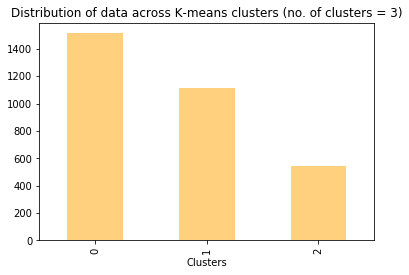

In [9]:
pd.value_counts(y_kmeans).plot(kind="bar", color="orange", alpha = 0.5)
plt.title("Distribution of data across K-means clusters (no. of clusters = 3)")
plt.xlabel("Clusters");

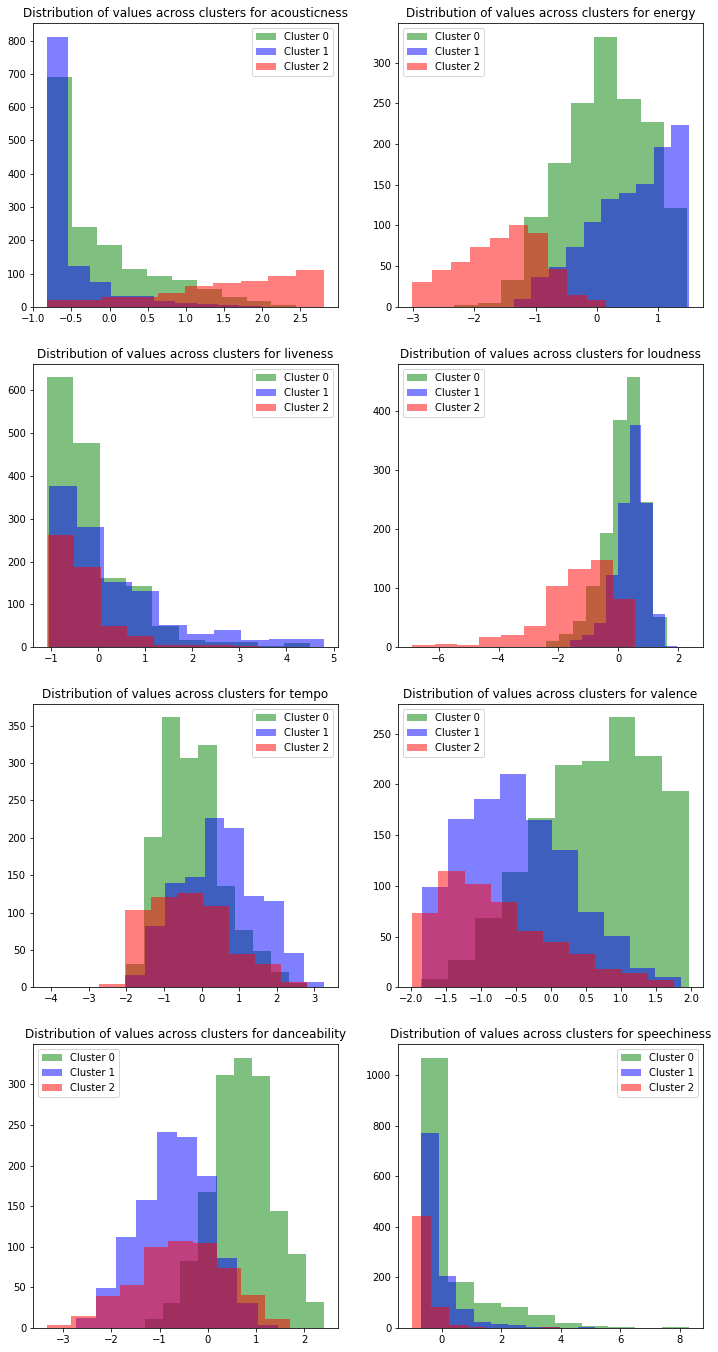

In [10]:
list_of_audio_features = ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']
fig, axes = plt.subplots(4,2,figsize=(12,24))
axes = axes.ravel()

for ax, i in zip(axes, list_of_audio_features):
    # plt.figure()
    ax.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 0, str(i)], color="green", alpha=0.5, label="Cluster 0")
    ax.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 1, str(i)], color="blue", alpha=0.5, label="Cluster 1")
    ax.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 2, str(i)], color="red", alpha=0.5, label="Cluster 2")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 3, str(i)], color="orange", alpha=0.5, label="Cluster 3")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 4, str(i)], color="pink", alpha=0.5, label="Cluster 4")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 5, str(i)], color="brown", alpha=0.5, label="Cluster 5")
    ax.legend();
    ax.set_title("Distribution of values across clusters for " + str(i))

## Recommender system model

In [11]:
# get list of artists

print("Select your favourite artist & song for us to understand you better!")

artists_list = songs_df['artist_name'].unique().tolist()
artist_name = ""
tracks_list = [""]
track_name = ""
track_uri = ""
input_orig_playlist = [""]

# sort list
artists_list.sort()

artist_names = widgets.Dropdown(
    options=artists_list,
    value=artists_list[0],
    description='Select Artist:',
    disabled=False,
)

track_names = widgets.Dropdown(
    options=tracks_list,
    value=tracks_list[0],
    description='Select Track:',
    disabled=True,
)

def on_change_artist(change):
    
    if change['type'] == 'change' and change['name'] == 'value':
        global artist_name, tracks_list
        
        artist_name = change['new']
        tracks_list = songs_df[songs_df['artist_name'] == artist_name]['track_name'].unique().tolist()
        tracks_list.sort()
        
        track_names.options = tracks_list
        track_names.value = tracks_list[0]
        track_names.disabled = False

artist_names.observe(on_change_artist)

def on_change_track(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global track_name, track_uri, input_orig_playlist
        track_name = change['new']
        temp_df = songs_df[songs_df['artist_name'] == artist_name]
        track_uri = temp_df[temp_df['track_name'] == track_name]['track_uri'].iloc[0]
        input_orig_playlist[0] = track_name
#         print("{0}:{1} - {2}".format(artist_name, track_name, track_uri))

track_names.observe(on_change_track)        

display(artist_names)
display(track_names)

Select your favourite artist & song for us to understand you better!


Dropdown(description='Select Artist:', options=('070 Shake', '10cc', '22 Savage', '2Cellos', '2Pac', '3OH!3', …

Dropdown(description='Select Track:', disabled=True, options=('',), value='')

In [13]:
#Cluster 0 has high danceability, medium-high energy, high valence, and relatively high speechiness
#Cluster 1 has medium danceability, high energy, medium valence, and medium speechiness
#Cluster 2 has medium danceability, low energy, low valence, and low speechiness

try:
    # input_orig_playlist = input_orig_playlist.value.split("; ")
    assigned_clusters_orig = []
    for i in input_orig_playlist:
        assigned_clusters_orig.append(y_kmeans[(np.where(np.array(songs_df['track_name'])==i))][0])

    initial_tracks_clusters = np.argmax(np.bincount(assigned_clusters_orig))
    #initial_tracks_clusters = y_kmeans[(np.where(np.array(songs_df['track_name'])== input_orig_playlist[0])[0][0])]
except:
    print("We couldn't continue - make sure you entered in your playlist in the previous code cell (and re-run it this time).")
    print("\nIf you did and you still see this, it seems you might have a typo or the song might not be in our database - try again (maybe with a new song)!")
    raise StopExecution
    
#Maybe do an argmax here, figure out the cluster that most tracks are assigned to and use that.

if initial_tracks_clusters == 0:
    default_danceability = "Yes"
    default_energy = "A little" #Or maybe Yes?
    default_valence = "Happy"
    default_speechiness = "Yes"
elif initial_tracks_clusters == 1:
    default_danceability = "A little"
    default_energy = "Yes" 
    default_valence = "Happy" #This is actually medium, so happy or sad (maybe in the middle)?
    default_speechiness = "A little"
elif initial_tracks_clusters == 2:
    default_danceability = "A little"
    default_energy = "No"
    default_valence = "Sad"
    default_speechiness = "No"

print("Hey! Based on the song you listen to, we figured out your preferences (see below)!")
print("If you don't agree with them, click on what best matches your interests and we'll override what we came up with.")
print("\nIf you click on the 'Suprise me!', you'll be given a random playlist (you don't need to select any other options).")
print("\nNote: If you want to start over, re-running this cell will clear all your input!")
print("-------------------")

input_mood = widgets.RadioButtons(
    options=['Happy', 'Sad', "Suprise me!"],
    value=default_valence,
    description='Feeling?')

display(input_mood)


print("How do you like your songs?")
input_speechiness = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Speechy?',
    value=default_speechiness,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

input_danceability = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Danceable?',
    disabled=False,
    value=default_danceability,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

print("Hint: Classical music is less energetic, and death metal has high energy.")
input_energy = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Energy?',
    disabled=False,
    value=default_energy,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

display(input_speechiness, input_danceability, input_energy)

#print("Please rank these artists:")
artists = ['Yiruma', 'Enya', 'Yani']
for i in artists:
    favorite_artists = widgets.IntSlider(
        value=5,
        min=0,
        max=10,
        step=1,
        description='Rank ' + str(i),
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    #display(favorite_artists)
#print("Once you're done, run the next ipython cell (not this one!)")

done_button = widgets.Button(
    value=False,
    description="Done? Click me!",
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

#done_button.on_click(other_stuff) 
#if done_flag == "Done":
display(done_button)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

done_button.on_click(run_all)

Hey! Based on the song you listen to, we figured out your preferences (see below)!
If you don't agree with them, click on what best matches your interests and we'll override what we came up with.

If you click on the 'Suprise me!', you'll be given a random playlist (you don't need to select any other options).

Note: If you want to start over, re-running this cell will clear all your input!
-------------------


RadioButtons(description='Feeling?', options=('Happy', 'Sad', 'Suprise me!'), value='Happy')

How do you like your songs?
Hint: Classical music is less energetic, and death metal has high energy.


ToggleButtons(description='Speechy?', index=3, options=('No', 'A little', "I don't know", 'Yes'), value='Yes')

ToggleButtons(description='Danceable?', index=3, options=('No', 'A little', "I don't know", 'Yes'), value='Yes…

ToggleButtons(description='Energy?', index=1, options=('No', 'A little', "I don't know", 'Yes'), value='A litt…

Button(description='Done? Click me!', icon='check', style=ButtonStyle(), tooltip='Description')

<IPython.core.display.Javascript object>

In [0]:
#Cluster 0 has high danceability, medium-high energy, high valence, and relatively high speechiness
#Cluster 1 has medium danceability, high energy, medium valence, and medium speechiness
#Cluster 2 has medium danceability, low energy, low valence, and low speechiness

if input_mood.value == 'Sad':
    sorting_hat = "Clusters 1 and 2"
elif input_mood.value == 'Happy':
    #Only one cluster for happy. Is that a good thing? - TODO
    sorting_hat = 0   
elif input_mood.value == "Pick for me":
    #Pick a cluster randomly
    sorting_hat = random.randint(0, 2)

if sorting_hat == "Clusters 1 and 2":
    #Not really considering speechiness in this case, since most songs in the data aren't speechy anyways
    if input_energy.value == "No" or input_energy.value == "A little":
        #Music question: How can you have medium danceability and low energy?
        sorting_hat = 2
    elif input_energy.value == "Yes":
        sorting_hat = 1
    
#This is not really necessary, just to show we give priority to the sorting hat
#and that we hope that user's preferences will meet our initial guess (in that case, no need for the sorting hat)
if initial_tracks_clusters == sorting_hat: 
    ideal_cluster_type = initial_tracks_clusters
else:
    #Give priority to the sorting hat
    ideal_cluster_type = sorting_hat

In [0]:
orig = songs_df.pivot_table(index='track_name', columns = 'pid').fillna(0)
pivoted = csr_matrix(orig)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(pivoted)

recommendations = []

for i in input_orig_playlist:
    query_index = np.where(np.array(orig.index)==i)[0][0]
    distances, indices = model_knn.kneighbors(np.array(orig.iloc[query_index, :]).reshape(1, -1), n_neighbors = 30) #

    for i in range(0, len(distances.flatten())):
        if i != 0:
            if orig.index[indices.flatten()[i]] not in input_orig_playlist and orig.index[indices.flatten()[i]] not in recommendations:
                recommendations.append(orig.index[indices.flatten()[i]])

    #for i in range(0, len(distances.flatten())):
    #    if i == 0:
    #        print ("Recomendation for ", (orig.index[query_index]))
    #    else:
    #        recommendations.append(orig.index[indices.flatten()[i]])
    #        print ((i, orig.index[indices.flatten()[i]], distances.flatten()[i]))

Design choice here: We just generate multiple recommendations for each song (which means recommendations can repeat), so we only store recommendations that don't repeat. Is there a way to input the entire original playlist at once and not get repeating recommendations?

In [34]:
print("By the way, in case you're curious, the songs you input mostly belong to cluster", initial_tracks_clusters)

By the way, in case you're curious, the songs you input mostly belong to cluster 0


In [39]:
ranks = []

res_df_ca = pd.DataFrame(columns=['Artist', 'Track', "Album", 'URL'])

print("Recommendations from the clustering analysis: ")

i = 0
for rec in recommendations:
    res = songs_df[songs_df['track_name'] == rec].iloc[0,:]
    #Find out cluster of track
    cluster_track = y_kmeans[(np.where(np.array(songs_df['track_name'])== rec)[0][0])]
    #print(i, cluster_track)
    if cluster_track == ideal_cluster_type:
        ranks.append(i)
        # track_uri_str = songs_df.loc[songs_df['track_name'] == i,'track_uri']
        track_uri_str = songs_df.loc[songs_df['track_name'] == rec,'track_uri'].to_list()[0]
        # track_uri_str = str(track_uri_str).split("track:",1)[1].rsplit("\nName",1)[0]
        track_uri_str = track_uri_str.split("track:", 1)[1]
        track_uri_url = 'https://open.spotify.com/track/' + track_uri_str
        # print("*", i, "*", "\n -> Link to track on Spotify", track_uri_url)
        print("*", rec, "* ", track_uri_url)
        i += 1
        res_df_ca.loc[i] = [res['artist_name'], res['track_name'], res['album_name'], track_uri_url]
        if i == 10: # max 10 recommendations
          break

# print("-"*20)
# res_df_ca[['Artist', 'Track', 'URL']]

#TODO: Narrow recommendations even further
#If song is between 25% and 50%, it's a little
#If song is below 25%, it's a No
#If the song is above 50%, it's a yes

Recommendations from the clustering analysis: 
* Set Fire to the Rain *  https://open.spotify.com/track/3CKCZ9pfwAfoMZlMncA1Nc
* Just Give Me a Reason *  https://open.spotify.com/track/1mKXFLRA179hdOWQBwUk9e
* Thinking Out Loud *  https://open.spotify.com/track/1Slwb6dOYkBlWal1PGtnNg
* Riptide *  https://open.spotify.com/track/7yq4Qj7cqayVTp3FF9CWbm
* Stitches *  https://open.spotify.com/track/1WP1r7fuvRqZRnUaTi2I1Q
* Wagon Wheel *  https://open.spotify.com/track/3xdjjKMcMOFgo1eQrfbogM
* Royals *  https://open.spotify.com/track/2dLLR6qlu5UJ5gk0dKz0h3
* On Top Of The World *  https://open.spotify.com/track/4eLSCSELtKxZwXnFbNLXT5
* Cheap Thrills *  https://open.spotify.com/track/27SdWb2rFzO6GWiYDBTD9j
* What Makes You Beautiful *  https://open.spotify.com/track/3SPDQfj2UfWq6A2NllZnzn


In [41]:
from IPython.display import display, HTML

print("Recommendations from the clustering analysis: ")
print("-"*50)
display(HTML(res_df_ca.to_html()))

Recommendations from the clustering analysis: 
--------------------------------------------------


,Artist,Track,Album,URL
1,Adele,Set Fire to the Rain,21,https://open.spotify.com/track/3CKCZ9pfwAfoMZlMncA1Nc
2,P!nk,Just Give Me a Reason,The Truth About Love,https://open.spotify.com/track/1mKXFLRA179hdOWQBwUk9e
3,Ed Sheeran,Thinking Out Loud,x,https://open.spotify.com/track/1Slwb6dOYkBlWal1PGtnNg
4,Vance Joy,Riptide,Dream Your Life Away,https://open.spotify.com/track/7yq4Qj7cqayVTp3FF9CWbm
5,Shawn Mendes,Stitches,Handwritten,https://open.spotify.com/track/1WP1r7fuvRqZRnUaTi2I1Q
6,Darius Rucker,Wagon Wheel,True Believers,https://open.spotify.com/track/3xdjjKMcMOFgo1eQrfbogM
7,Lorde,Royals,Pure Heroine,https://open.spotify.com/track/2dLLR6qlu5UJ5gk0dKz0h3
8,Imagine Dragons,On Top Of The World,Night Visions,https://open.spotify.com/track/4eLSCSELtKxZwXnFbNLXT5
9,Sia,Cheap Thrills,This Is Acting,https://open.spotify.com/track/27SdWb2rFzO6GWiYDBTD9j
10,One Direction,What Makes You Beautiful,Up All Night,https://open.spotify.com/track/3SPDQfj2UfWq6A2NllZnzn


In [17]:
print("Recommendations that aren't based on clustering analysis: ")
recommendations

Recommendations that aren't based on clustering analysis: 


['I Will Wait',
 'Lover Of The Light',
 'Set Fire to the Rain',
 'Hello',
 'Let Her Go',
 'Just Give Me a Reason',
 'Thinking Out Loud',
 'Riptide',
 'Stitches',
 'Roar',
 'Stay With Me',
 'Wagon Wheel',
 'Royals',
 'On Top Of The World',
 'Cheap Thrills',
 'What Makes You Beautiful',
 'Gold',
 'i',
 "The Green Fields Of France (No Man's Land)",
 'When You Believe',
 'Keep Your Head Up',
 'This Is How We Do It',
 'You Raise Me Up',
 "The Man Who Can't Be Moved - EP Version",
 'Shake It Out',
 "Roll Away Your Stone - Live At Shepherd's Bush Empire",
 'What The Water Gave Me',
 'Letter 2 My Unborn',
 "I'm Alive"]

# Recommendation using Language Model

### Basis
As language models such as BERT trained on Wikipedia, along with other sources, when it generates word embeddings in it's high dimensional space, it would bring out relationships that we are not able to capture using conventional techniques.

### 1. Inputs
Generated word embedding (768 dimensional) for each song. Currently we are using Artist Name, Album Name & Song name to generate work embeddings. In future, we can use song Lyrics to get a more accurate represenation

### 2. Generate Search Index
To efficiently generate recommendations, we need to check for the statistical distance between vectors of chosen song (in earlier step above), and select ones from the dataset that is the closest. 

We create an index using the simplest version that just performs brute-force L2 distance search. For this we use FAISS (Facebook AI Similarity Search). 

We explored other options using as Spotify's ANNOY (Approximate Nearest Neighbours), but we finally found FAISS as the simplest and fastest for our requirement

### 3. Search
We use the search index generated in the step above to search for possible recommendations. We use the following filter criteria:
1. No songs from the original artist
2. No songs from the original album
3. Only 1 recommendation per new artist



### Step 0 - Setup

1. Install faiss package
2. Install libomp-dev required. The libomp-dev requirement would vary across operating systems. See: # https://github.com/facebookresearch/faiss/issues/821

In [18]:
# install faiss - Facebook AI - Similarity Search
# also evaluated annoy (Approximate Nearest Neighbors) - https://github.com/spotify/annoy

# faiss is a library for efficient similarity search and clustering of dense vectors
!pip install faiss
# https://github.com/facebookresearch/faiss/issues/821
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  default-jre dkms freeglut3 freeglut3-dev keyboard-configuration libargon2-0
  libcap2 libcryptsetup12 libdevmapper1.02.1 libfontenc1 libgtk2.0-0
  libgtk2.0-common libidn11 libip4tc0 libjansson4 libnvidia-cfg1-440
  libnvidia-common-430 libnvidia-common-440 libnvidia-decode-440
  libnvidia-encode-440 libnvidia-fbc1-440 libnvidia-gl-440 libnvidia-ifr1-440
  

In [0]:
# utility function to download shared file on google drive without authentication
# CREDIT: https://stackoverflow.com/a/39225039

import requests

def progress_bar(some_iter):
    try:
        from tqdm import tqdm
        return tqdm(some_iter)
    except ModuleNotFoundError:
        return some_iter

def download_file_from_google_drive(id, destination):
  print("Trying to fetch {}".format(destination))

  def get_confirm_token(response):
    for key, value in response.cookies.items():
      if key.startswith('download_warning'):
        return value

    return None

  def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
      for chunk in progress_bar(response.iter_content(CHUNK_SIZE)):
        if chunk: # filter out keep-alive new chunks
          f.write(chunk)

  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()

  response = session.get(URL, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)

  save_response_content(response, destination)

In [0]:
# this function implements the logic to get recommendations

def get_ai_recommendations(index, track_details_df, track_uri, n):

  # inputs
  # index: index of the song vectors to search from
  # track_details_df: dataframe of song details
  # track_uri: URI for track to use as basis for recommendations

  # return
  # uri of recommended songs

  # import pprint

  # details of intitial song
  res = track_details_df[track_details_df['track_uri'] == track_uri]
  artist = res.iloc[0,0]
  song = res.iloc[0,1]
  album = res.iloc[0,2]
  song_index = track_details_df[track_details_df['track_uri'] == track_uri].index[0]
  # print("{0}-{1}({2})".format(res.iloc[0,0], res.iloc[0,1], res.iloc[0,2]))

  # get top 1000 nearest songs to search from
  ind = 0
  k = 1000 # we want to see 1000 nearest neighbors
  D, I = index.search(track_embeddings[song_index:song_index+1], k)

  recommendations = []
  recommendations_uri = []
  recommended_artists = []

  for d,i in zip(D[0], I[0]):
    if d > 0.0:

      ind += 1 # index
      res = track_details_df.loc[i,:]

      # skip artists with similar names
      if len(list(set(artist.split()) & set(res['artist_name'].split()))):
        # print(artist, res['artist_name'])
        continue
 
      # skip songs from same artist, albums, song names
      if artist in res['artist_name']  or album in res['album_name'] or res['track_name'] == song:
        continue
 
      # recommend artist only once
      if res['artist_name'] in recommended_artists:
        continue
      recommended_artists.append(res['artist_name'])
 
      # print("{0}. {1}-{2}({3}) : {4} ".format(ind, res['artist_name'], res['track_name'], res['album_name'], d))
      recommendations.append("{0}-{1}({2}): {3}".format(res['artist_name'], res['track_name'], res['album_name'], d))
      recommendations_uri.append(res['track_uri'])

      # check for max recommendation 
      if len(recommendations) == n:
        break

      if d > 30: # do not select songs whose distance is too far away
        break

  # pprint.pprint(recommendations)
  return recommendations_uri

### **Use BERT Language Models to generate recommendations**

### Step 1: Inputs

1. Download data from shared google drive link. Data is in form of a saved numpy array, in which the data structure has been "pickled"

2. Extract the track embeddings as a numpy array of 768 rows (vector dimension)

3. Extract the song details as a pandas dataframe.

*Note1*: The index of the embeddeding array, and the songs data frame is the common key between the two entities

*Note2*: We have about $113114$ songs in the index. The entire dataset has not been used to manage memory. We have tested this on a google colab instance with 12 GB RAM.

In [0]:
# download the precalcuated track vectors

# https://drive.google.com/file/d/1-2M9CIkX0MtPflfnG9CQQvU0nppyt6Xq/view?usp=sharing - part00

download_file_from_google_drive("1-2M9CIkX0MtPflfnG9CQQvU0nppyt6Xq", \
                                "./track_vectors-part00.npy")

# load track vectors
track_vectors = np.load("./track_vectors-part00.npy", allow_pickle=True)
track_embeddings = track_vectors[:,6:]

track_embeddings = track_embeddings.astype('float32')
track_details = track_vectors[:,0:6]

track_details_df = pd.DataFrame(track_details, columns = ['artist_name', 'track_name', 'album_name', 'track_uri', 'artist_uri','album_uri'])
del track_vectors, track_details

### Step 2: Generate the Index

In [23]:
# https://github.com/facebookresearch/faiss/wiki/Getting-started

import faiss

# create an index using the simplest version that just performs brute-force L2 distance search
index = faiss.IndexFlatL2(track_embeddings.shape[1]) # build the index
print("Index training status is {0}".format(index.is_trained))
index.add(track_embeddings) # add vectors to the index
print("No if elements in the index is {0}".format(index.ntotal))

Index training status is True
No if elements in the index is 113114


### Step 3: Generate recommendations

In [45]:
# get recommendations
ai_recommendations = get_ai_recommendations(index, track_details_df, track_uri, 10)

# empty dataframe to collect recommendations
res_df_ai = pd.DataFrame(columns=['Artist', 'Track', "Album", 'URL'])

print("Recommendations from the AI engine (BERT): \n")

for i, rec_uri in enumerate(ai_recommendations):
  res = track_details_df[track_details_df['track_uri'] == rec_uri].iloc[0,:]
  track_uri_str = str(res['track_uri']).split("track:",1)[1].rsplit("\nName",1)[0]
  track_uri_url = 'https://open.spotify.com/track/' + track_uri_str
  # print("{0} by {1} from the album {2}: {3}".format(res['track_name'], res['artist_name'], res['album_name'], track_uri_url))
  res_df_ai.loc[i] = [res['artist_name'], res['track_name'], res['album_name'], track_uri_url]
  print("*", res['track_name'], "*", track_uri_url)

# print recommendations
# print("-"*20)
# res_df_ai[['Artist', 'Track', 'URL']]

Recommendations from the AI engine (BERT): 

* Damage * https://open.spotify.com/track/6WBP1MnLCXU83olpijTZAr
* Every Time * https://open.spotify.com/track/5lgZax3wvO1oW3Bn0p9veJ
* The Look of Love - Remix * https://open.spotify.com/track/2BS3GDS8YNQIMV8XRUeKkC
* Into the Light * https://open.spotify.com/track/60bHmpZIWAnSjgtO1lJtr2
* 8701 * https://open.spotify.com/track/0gmYtRyuvRKpd6cCApSDTh
* Police and Theives * https://open.spotify.com/track/4C7ywbJNrB81ZYmKnPOj6S
* The Reach - Intro Mix * https://open.spotify.com/track/5fO6dEwcPqqn2zHEdB00eo
* Harden the Paint * https://open.spotify.com/track/7mlJpcVvVRzgGwkL3GUgY3
* The Calling * https://open.spotify.com/track/6ZaLSZT6R4Bxo4nHo9kTkp
* From The Window of My Room * https://open.spotify.com/track/106DEsh40VqUAJoGrRh6gG


In [46]:
from IPython.display import display, HTML

print("Recommendations from the AI Engine (BERT): ")
print("-"*50)
display(HTML(res_df_ai.to_html()))

Recommendations from the AI Engine (BERT): 
--------------------------------------------------


,Artist,Track,Album,URL
0,Chris Brown,Damage,Exclusive - The Forever Edition,https://open.spotify.com/track/6WBP1MnLCXU83olpijTZAr
1,Janet Jackson,Every Time,The Velvet Rope,https://open.spotify.com/track/5lgZax3wvO1oW3Bn0p9veJ
2,J-88,The Look of Love - Remix,Flipsides,https://open.spotify.com/track/2BS3GDS8YNQIMV8XRUeKkC
3,J.Views,Into the Light,401 Days,https://open.spotify.com/track/60bHmpZIWAnSjgtO1lJtr2
4,J.I.D,8701,The Never Story,https://open.spotify.com/track/0gmYtRyuvRKpd6cCApSDTh
5,J Boog,Police and Theives,J Boog - EP,https://open.spotify.com/track/4C7ywbJNrB81ZYmKnPOj6S
6,Audien,The Reach - Intro Mix,The Reach,https://open.spotify.com/track/5fO6dEwcPqqn2zHEdB00eo
7,Foster The People,Harden the Paint,Sacred Hearts Club,https://open.spotify.com/track/7mlJpcVvVRzgGwkL3GUgY3
8,Chris Lorenzo,The Calling,The Calling,https://open.spotify.com/track/6ZaLSZT6R4Bxo4nHo9kTkp
9,Cypress Hill,From The Window of My Room,IV,https://open.spotify.com/track/106DEsh40VqUAJoGrRh6gG


### **Use GPT-2 Language Models to generate recommendations**

### Step 1 - Input

In [47]:
# download the precalcuated track vectors

# https://drive.google.com/file/d/1-2M9CIkX0MtPflfnG9CQQvU0nppyt6Xq/view?usp=sharing - part00 - BERT
# https://drive.google.com/open?id=1VvPbasE3BbMwUg-pHz8eaaicQK0YZOeP - part00 - GPT-2
download_file_from_google_drive("1VvPbasE3BbMwUg-pHz8eaaicQK0YZOeP", \
                                "./track_vectors-part00-GPT2.npy")

# load track vectors
track_vectors = np.load("./track_vectors-part00-GPT2.npy", allow_pickle=True)
track_embeddings = track_vectors[:,6:]

track_embeddings = track_embeddings.astype('float32')
track_details = track_vectors[:,0:6]

track_details_df = pd.DataFrame(track_details, columns = ['artist_name', 'track_name', 'album_name', 'track_uri', 'artist_uri','album_uri'])
del track_vectors, track_details

Trying to fetch ./track_vectors-part00-GPT2.npy


24617it [00:09, 2522.09it/s]


### Step 2 - Index

In [48]:
# https://github.com/facebookresearch/faiss/wiki/Getting-started

import faiss

# create an index using the simplest version that just performs brute-force L2 distance search
index = faiss.IndexFlatL2(track_embeddings.shape[1]) # build the index
print("Index training status is {0}".format(index.is_trained))
index.add(track_embeddings) # add vectors to the index
print("No if elements in the index is {0}".format(index.ntotal))

Index training status is True
No if elements in the index is 113114


### Step 3 - Recommendations

In [49]:
# get recommendations
ai_recommendations = get_ai_recommendations(index, track_details_df, track_uri, 10)

# empty dataframe to collect recommendations
res_df_ai = pd.DataFrame(columns=['Artist', 'Track', "Album", 'URL'])

print("Recommendations from the AI engine (GPT-2): \n")

for i, rec_uri in enumerate(ai_recommendations):
  res = track_details_df[track_details_df['track_uri'] == rec_uri].iloc[0,:]
  track_uri_str = str(res['track_uri']).split("track:",1)[1].rsplit("\nName",1)[0]
  track_uri_url = 'https://open.spotify.com/track/' + track_uri_str
  # print("{0} by {1} from the album {2}: {3}".format(res['track_name'], res['artist_name'], res['album_name'], track_uri_url))
  res_df_ai.loc[i] = [res['artist_name'], res['track_name'], res['album_name'], track_uri_url]
  print("*", res['track_name'], "*", track_uri_url)

# print recommendations
# print("-"*20)
# res_df_ai[['Artist', 'Track', 'URL']]

Recommendations from the AI engine (GPT-2): 

* Summer * https://open.spotify.com/track/0BmJsqTCp4cz2xxaMGVD7n
* Reload * https://open.spotify.com/track/7hfLxeKcjVkaw2tgw5IH9Q
* Bitter Truth * https://open.spotify.com/track/78kwvVtF0WMnrI0Se1X4uD
* Arcades * https://open.spotify.com/track/1TDuaeF7FnV74z57NK7hh4
* Ready or not * https://open.spotify.com/track/4rNmXDO7swYl6RsK386r89
* Switch * https://open.spotify.com/track/02LZ1fGJE8fB56yTlCVMEV
* Andele * https://open.spotify.com/track/0ExAvK8LOBqvLvFl6TtZwG
* Trees and Flowers * https://open.spotify.com/track/0MFQjOEqrlvLJP0j1IWlsw
* Cold * https://open.spotify.com/track/1QWmKmqhv5zcsS3v45FNl0
* Float * https://open.spotify.com/track/3ttUHX4JqTremHnnF6AkoP


In [50]:
from IPython.display import display, HTML

print("Recommendations from the AI Engine (GPT-2): ")
print("-"*50)
display(HTML(res_df_ai.to_html()))

Recommendations from the AI Engine (GPT-2): 
--------------------------------------------------


,Artist,Track,Album,URL
0,Sum 41,Summer,Half Hour Of Power,https://open.spotify.com/track/0BmJsqTCp4cz2xxaMGVD7n
1,Gorilla Zoe,Reload,I Am Atlanta 3,https://open.spotify.com/track/7hfLxeKcjVkaw2tgw5IH9Q
2,Iron & Wine,Bitter Truth,Beast Epic,https://open.spotify.com/track/78kwvVtF0WMnrI0Se1X4uD
3,C2C,Arcades,Tetra,https://open.spotify.com/track/1TDuaeF7FnV74z57NK7hh4
4,Meek Mill,Ready or not,Dream Chaser 4,https://open.spotify.com/track/4rNmXDO7swYl6RsK386r89
5,Iggy Azalea,Switch,Switch,https://open.spotify.com/track/02LZ1fGJE8fB56yTlCVMEV
6,Young Buck,Andele,10 Bodies,https://open.spotify.com/track/0ExAvK8LOBqvLvFl6TtZwG
7,Dum Dum Girls,Trees and Flowers,End of Daze,https://open.spotify.com/track/0MFQjOEqrlvLJP0j1IWlsw
8,Post Malone,Cold,Stoney,https://open.spotify.com/track/1QWmKmqhv5zcsS3v45FNl0
9,Love Battery,Float,Far Gone,https://open.spotify.com/track/3ttUHX4JqTremHnnF6AkoP


## Unrelated items below (PCA analysis, predicting position of track in playlist)

#TODO: Relies on the fact that scaled_df and songs_df still have same indices! Remember kmeans model is trained on the scaled_df!

Un-toggle code button to see code:

In [0]:
    
"""    
if input_speechiness == "No":
    print("Tending towards Cluster 2")
elif input_speechiness == "A little"
    
if input_danceability == "No":
    print("Cluster 2")
    
if input_danceability == "A little":
    print("Tending towards Cluster 1")

if input_energy == "No":
    print("Cluster 2")
    
if input_energy == "A little":
    print("Cluster 0")
"""

In [0]:
new_scaled_df.describe()

In [0]:
pca = PCA().fit(new_scaled_df)
pca_2d = pca.transform(new_scaled_df)
pcaX_train_df = pd.DataFrame(pca_2d)

In [0]:
list_of_audio_features = ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']

In [0]:
for column_plot in ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']:
    
    cut_off = round(np.median(new_scaled_df[column_plot]), 4)
    df_y_train = pd.DataFrame(new_scaled_df[column_plot]).set_index(pcaX_train_df.index)
    
    plt.figure()
    plt.scatter(pcaX_train_df.loc[df_y_train[column_plot] < cut_off, 0], pcaX_train_df.loc[df_y_train[column_plot] < cut_off, 1], alpha=0.4, label= str(column_plot) + "<" + str(cut_off))
    plt.scatter(pcaX_train_df.loc[df_y_train[column_plot] >= cut_off, 0], pcaX_train_df.loc[df_y_train[column_plot] >= cut_off, 1], alpha=0.4, label= str(column_plot) + ">=" + str(cut_off))

    plt.xlabel("First PCA Component Vector")
    plt.ylabel("Second PCA Component Vector")
    plt.title("First two principal components: Results for binning " + str(column_plot))
    plt.legend();

In [0]:
print("Variance explained by top two components", pca.explained_variance_ratio_[0:2])

In [0]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of PCA components used")
plt.ylabel("Cumulative explained variability")
plt.title("Cumulative explained variability from PCA components");

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(pcaX_train_df)
y_kmeans = kmeans.predict(pcaX_train_df)

plt.scatter(pcaX_train_df[0], pcaX_train_df[1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("K-means clustering results on PCA (no. of clusters = 3)");

## Models for predicting position of track in playlist

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_scaled_df, songs_df['pos'], test_size=0.33, random_state=42)

In [0]:
logreg = LogisticRegression(C=100000, fit_intercept=False, solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
logreg.predict(X_train)
logreg.score(X_test, y_test)

In [0]:
linearreg = LinearRegression()
linearreg.fit(X_train, y_train)
linearreg.score(X_test, y_test)